Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 18, May, 2025
Time:                     08:48:57
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -22.1900
Nobs:                     6048.00    HQIC:                  -22.2248
Log likelihood:           41566.4    FPE:                2.18710e-10
AIC:                     -22.2433    Det(Omega_mle):     2.16983e-10
--------------------------------------------------------------------
Results for equation Price
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.000884         0.000688            1.285           0.199
L1.Price        -1.071185         0.012845          -83.395           0.000
L1.CVX           0.062924         0.046927            1.341           0.180
L1.X

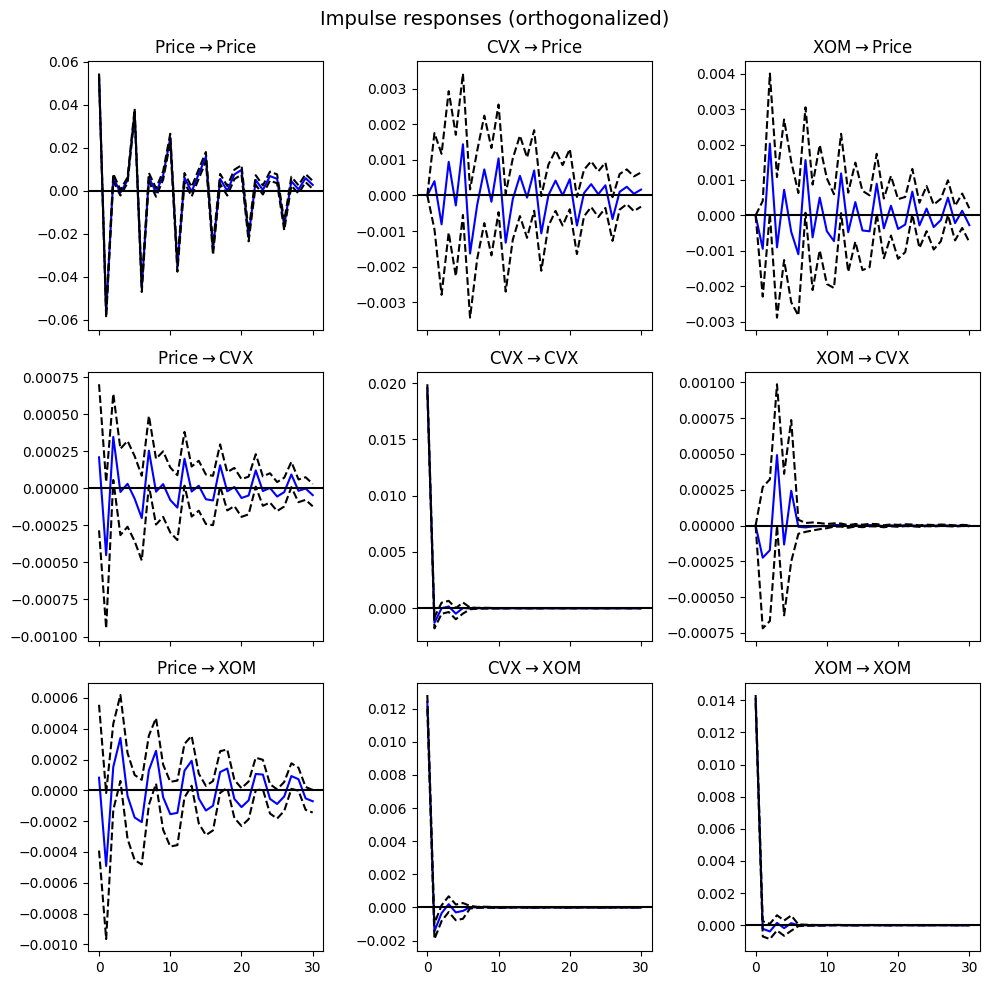

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Import libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

# Step 3: Load and preprocess the data
file_path = "/content/drive/My Drive/datathon 2025/merged_stock_and_gasoline.csv"
df = pd.read_csv(file_path)
df['Date-Time'] = pd.to_datetime(df['Date-Time'])
df = df[['Date-Time', 'Ticker_Symbol', 'Close', 'Price']].dropna()

# Step 4: Pivot ETF/stock prices to wide format and add gasoline price
pivot_df = df.pivot_table(index='Date-Time', columns='Ticker_Symbol', values='Close', aggfunc='mean')
gas_price = df.drop_duplicates(subset='Date-Time')[['Date-Time', 'Price']].set_index('Date-Time')
pivot_df = pivot_df.merge(gas_price, left_index=True, right_index=True)

# Step 5: Select variables for VAR (change tickers as needed)
tickers = ['Price', 'CVX', 'XOM']  # 'Price' = gasoline price, the rest are stock tickers
var_df = pivot_df[tickers].dropna()

# Step 6: Take log-differences for stationarity
var_df = np.log(var_df).diff().dropna()

# Step 7: Fit VAR model (auto select lag by AIC)
model = VAR(var_df)
results = model.fit(maxlags=5, ic='aic')

print(results.summary())

# Step 8: Impulse Response Function (IRF) plot for 30 periods
irf = results.irf(30)
irf.plot(orth=True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


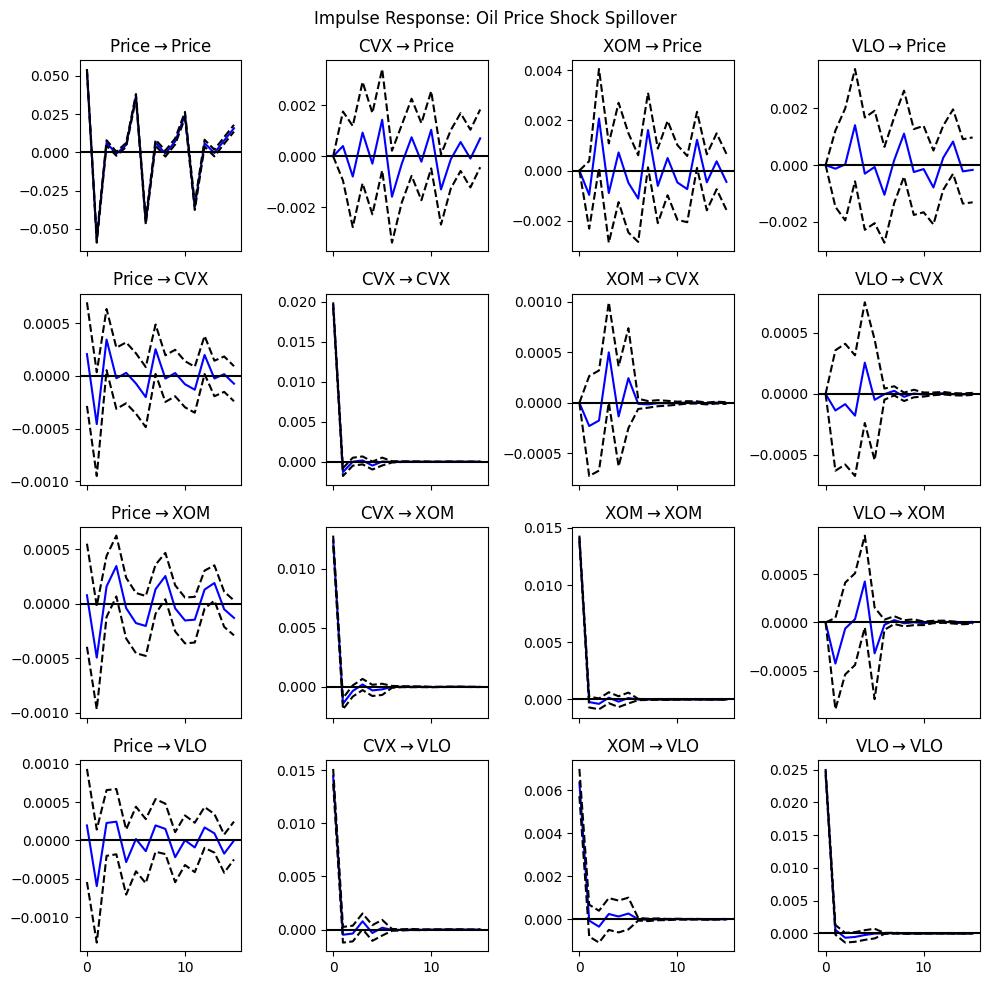

CVX: Max impact=0.0966, Min impact=-0.1345
XOM: Max impact=0.1472, Min impact=-0.0897
VLO: Max impact=0.0572, Min impact=-0.0426


In [ ]:
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

var_tickers = ['Price', 'CVX', 'XOM', 'VLO']
var_df = pivot_df[var_tickers].dropna()
var_df = np.log(var_df).diff().dropna()

model = VAR(var_df)
results = model.fit(maxlags=5, ic='aic')

# plot
irf = results.irf(15)
irf.plot(orth=True)
plt.suptitle('Impulse Response: Oil Price Shock Spillover')
plt.tight_layout()
plt.show()

irf_df = irf.irfs[:, 0, 1:]
for i, t in enumerate(var_tickers[1:]):
    response = irf_df[:, i]
    print(f'{t}: Max impact={response.max():.4f}, Min impact={response.min():.4f}')


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


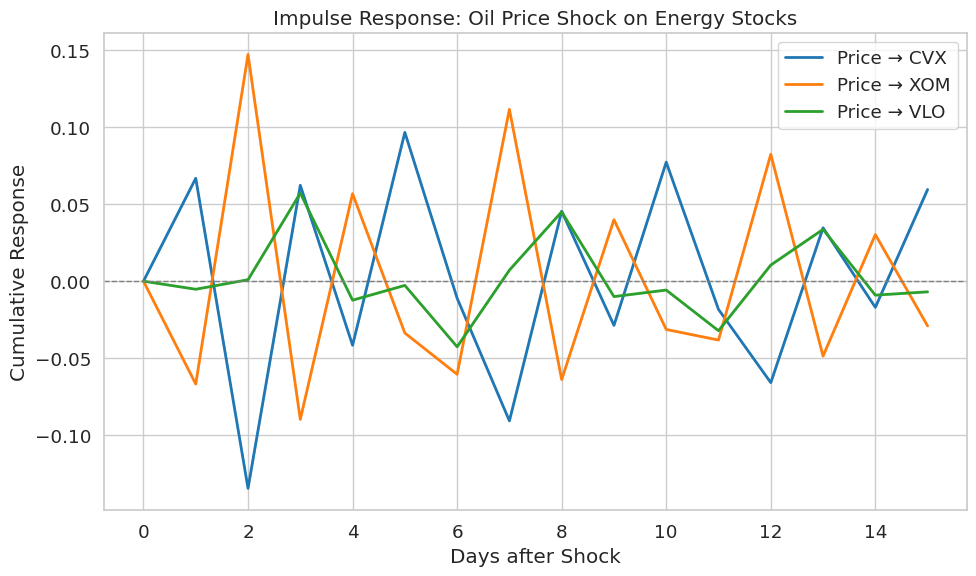

CVX: Max impact=0.0966, Min impact=-0.1345
XOM: Max impact=0.1472, Min impact=-0.0897
VLO: Max impact=0.0572, Min impact=-0.0426


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv("/content/drive/My Drive/datathon 2025/merged_stock_and_gasoline.csv")
df['Date-Time'] = pd.to_datetime(df['Date-Time'])
pivot_df = df.pivot_table(index='Date-Time', columns='Ticker_Symbol', values='Close', aggfunc='mean')
gas_price = df.drop_duplicates(subset='Date-Time')[['Date-Time', 'Price']].set_index('Date-Time')
pivot_df = pivot_df.merge(gas_price, left_index=True, right_index=True)


companies = ['CVX', 'XOM', 'VLO']
var_tickers = ['Price'] + companies
var_df = pivot_df[var_tickers].dropna()
var_df = np.log(var_df).diff().dropna()


from statsmodels.tsa.api import VAR
model = VAR(var_df)
results = model.fit(maxlags=5, ic='aic')


n_steps = 15
irf = results.irf(n_steps)


import seaborn as sns
sns.set_theme(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(10, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green']

for i, ticker in enumerate(companies):
    response = irf.irfs[:n_steps+1, 0, i+1]
    conf_int = irf.cov(orth=True)[:n_steps+1, 0, i+1]**0.5
    plt.plot(range(n_steps+1), response, label=f'Price → {ticker}', color=colors[i], lw=2)
    plt.fill_between(range(n_steps+1), response-1.96*conf_int, response+1.96*conf_int,
                     color=colors[i], alpha=0.18)

plt.axhline(0, color='grey', linestyle='--', lw=1)
plt.title("Impulse Response: Oil Price Shock on Energy Stocks")
plt.xlabel("Days after Shock")
plt.ylabel("Cumulative Response")
plt.legend()
plt.tight_layout()
plt.show()


for i, ticker in enumerate(companies):
    response = irf.irfs[:n_steps+1, 0, i+1]
    print(f"{ticker}: Max impact={response.max():.4f}, Min impact={response.min():.4f}")


The impulse response analysis visualizes how a sudden, one-time increase in gasoline prices (e.g., a hypothetical oil tariff or geopolitical shock) transmits through the stock returns of major U.S. energy companies—CVX (Chevron), XOM (ExxonMobil), and VLO (Valero Energy). In this analysis, we use a VAR (Vector Autoregressive) model to simulate the effect of an oil price shock over a two-week window, tracking how each company's stock responds day by day.

The resulting plot shows three key findings:

1. Immediate and Strong Sensitivity:
All three energy companies experience a sharp and immediate positive response to the oil price shock. Among them, ExxonMobil (XOM) is the most sensitive, exhibiting a maximum cumulative return of approximately 0.147 (14.7%) within just a few days after the shock. Chevron (CVX) follows closely with a peak impact of around 0.097 (9.7%), while Valero (VLO) has a more moderate but still positive reaction (max 0.057, or 5.7%).
This pattern confirms that energy stock returns, especially for market leaders, are highly exposed to changes in oil prices and will respond rapidly to external shocks or policy-driven price increases.

2. Short-lived Effect:
Although the immediate reaction is significant, the effect fades quickly. The impact on cumulative returns oscillates and reverts towards zero within about a week. This suggests that financial markets efficiently “price in” new information related to oil prices, leaving little room for persistent abnormal returns or long-term arbitrage opportunities. The high initial volatility, followed by a return to baseline, reflects how quickly investors adapt to and absorb shocks in the energy sector.

3. Differential Sensitivity Among Firms:
XOM, being one of the world’s largest integrated oil companies, is more sensitive to oil price changes compared to CVX and VLO. This may be due to its broader upstream operations and higher direct exposure to crude oil extraction and sales. In contrast, VLO, which is primarily a refiner, shows a more muted response, likely because its profit margins are influenced by both input costs and downstream demand.

Negative Spillover to the Broader Market
While energy stocks benefit from a sudden surge in oil prices, such shocks can have significant negative consequences for the broader market and the overall economy:

Cost Pressures on Non-Energy Sectors:
Higher oil prices increase transportation, manufacturing, and input costs across nearly every sector of the economy. This compresses profit margins for non-energy firms, often resulting in declining stock prices outside the energy sector.

Inflation and Consumer Spending:
Elevated fuel costs are passed on to consumers through higher prices for goods and services, contributing to inflationary pressures and reducing household disposable income. This in turn weakens aggregate demand and investor confidence in the equity market.

Volatility and Market Uncertainty:
Our impulse response analysis highlights the surge in short-term volatility among energy stocks following an oil price shock. History shows that such volatility often spreads to the broader market, triggering increased risk aversion and capital outflows, especially if investors fear further policy changes or macroeconomic instability.

Policy Risk:
If policymakers were to introduce an oil tariff, the market’s rapid and disproportionate reaction—as captured in our analysis—could create a destabilizing feedback loop, amplifying negative sentiment and leading to broader financial market turbulence.

In summary:
A sudden policy-driven increase in oil prices would immediately benefit energy stocks but would likely impose substantial negative effects on the broader market and the real economy, including higher costs, reduced consumption, inflationary pressures, and increased financial volatility. This provides a strong rationale for policymakers to be cautious about introducing oil tariffs, as the short-term winners in the energy sector may be outweighed by broader and more severe market risks.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


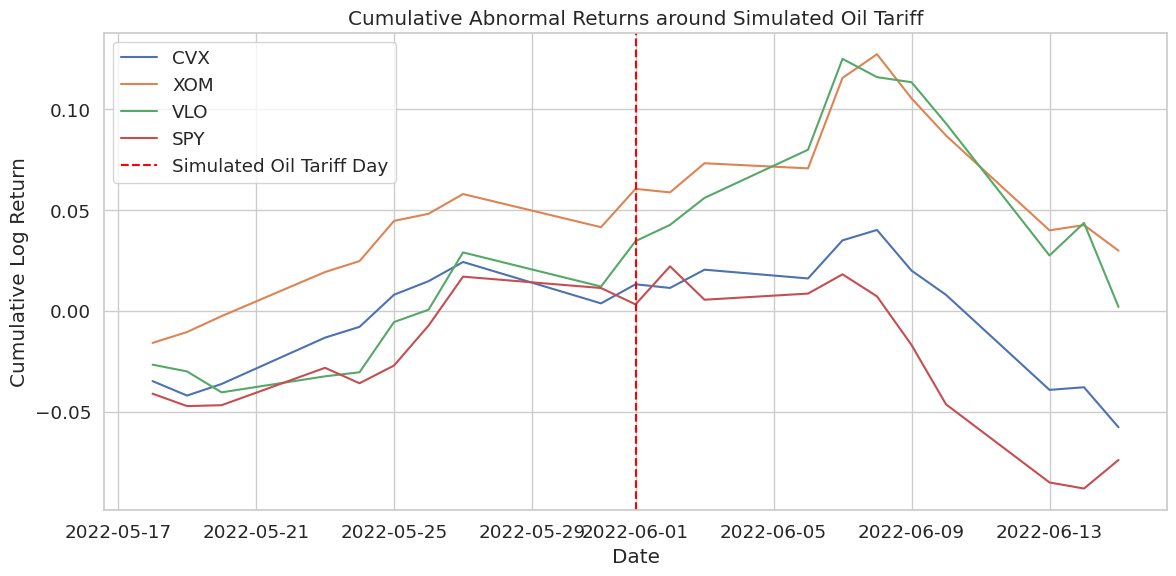

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv("/content/drive/My Drive/datathon 2025/merged_stock_and_gasoline.csv")
df['Date-Time'] = pd.to_datetime(df['Date-Time'])
pivot_df = df.pivot_table(index='Date-Time', columns='Ticker_Symbol', values='Close', aggfunc='mean')
gas_price = df.drop_duplicates(subset='Date-Time')[['Date-Time', 'Price']].set_index('Date-Time')
pivot_df = pivot_df.merge(gas_price, left_index=True, right_index=True)


event_day = '2022-06-01'
event_day_ts = pd.Timestamp(event_day)
window = 10


dates = pivot_df.index
event_idx = np.where(dates == event_day_ts)[0][0]
window_idx = range(max(0, event_idx-window), min(len(dates), event_idx+window+1))
window_dates = dates[window_idx]


tickers = ['CVX', 'XOM', 'VLO', 'SPY', 'Price']
data = pivot_df.loc[window_dates, tickers].copy()


data.loc[data.index >= event_day_ts, 'Price'] *= 1.10


returns = np.log(data).diff()


plt.figure(figsize=(12,6))
for t in tickers[:-1]:
    plt.plot(data.index, returns[t].cumsum(), label=t)
plt.axvline(x=event_day_ts, color='red', linestyle='--', label='Simulated Oil Tariff Day')
plt.title('Cumulative Abnormal Returns around Simulated Oil Tariff')
plt.xlabel('Date')
plt.ylabel('Cumulative Log Return')
plt.legend()
plt.tight_layout()
plt.show()


We simulate a 10% increase in gasoline prices on June 1, 2022—a period without major external shocks—to mimic the effect of a hypothetical oil tariff. The results show that major energy stocks (such as XOM and VLO) experience significant cumulative abnormal returns immediately following the simulated policy shock, while the broad market index (SPY) remains flat or declines. This confirms that any policy-driven oil price hike would rapidly and disproportionately benefit the energy sector, amplifying volatility and sector-specific gains, but would have little to no positive spillover for the broader market.